In [1]:
"""
Chris Hareland, Northwestern University.

Perform the calculations for the Ag-Cu system with thermodynamic data from Murray (1984). 

Written with:
    python 3.8.3
    matplotlib 3.2.2
    numpy 1.18.5
    scipy 1.5.0

References:
    - Murray (1984) "Calculations of Stable and Metastable Equilibrium Diagrams of the Ag-Cu and Cd-Zn Systems", Metallurgical Transactions A 15(2), 261-268.
    - Tong & Beckermann (1998) "A diffusion boundary layer model of microsegregation", Journal of Crystal Growth 187, 289-302.
    - Maguin et al. (2019) "Finite diffusion microsegregation model applied to multicomponent alloys", IOP Conference Series: Materials Science and Engineering 529, 012029.
    - Martin et al. (2024) "Kinetic effects during the plane-front and dendritic solidification of multicomponent alloys", Acta Materialia 263, 119473.
"""

import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


In [2]:
def tong_and_beckermann_ode(solid_fraction, solid_composition, liquid_modified_fourier_number, alloy_composition, partition_coefficient):
    """Tong & Beckermann Eqs. 13 and 14."""
    F1 = 2*liquid_modified_fourier_number*solid_fraction/partition_coefficient * (1-np.exp(-(1-solid_fraction)/(2*liquid_modified_fourier_number*solid_fraction)))
    F2 = (alloy_composition-solid_composition) + (solid_composition/partition_coefficient-alloy_composition) * (np.exp(-(1-solid_fraction)/(2*liquid_modified_fourier_number*solid_fraction))/solid_fraction - 2*liquid_modified_fourier_number*(1-np.exp(-(1-solid_fraction)/(2*liquid_modified_fourier_number*solid_fraction))))
    return F2/F1

TB_solution = solve_ivp(tong_and_beckermann_ode, (2.5e-5, 0.99), np.asarray([0.144]), args=(0.196,0.15,0.588), method='RK45', t_eval=np.linspace(2.5e-5,0.99,1000))


In [3]:
class AgCu_Murray1984:
    """Thermodynamic parameters for the Ag-Cu system from Murray."""
    def __init__(self, T, xb, phase):
        self.R = 8.314
        self.T = T
        self.xb = xb

        if phase=='solid':
            self.G_Ag_o = -11945 + 9.67*self.T
            self.G_Cu_o = -13054 + 9.62*self.T
            self.f = 34532 - 9.178*self.T
            self.f2 = -5996 + 1.725*self.T
        elif phase=='liquid':
            self.G_Ag_o = 0
            self.G_Cu_o = 0
            self.f = 15171 - 2.537*self.T
            self.f2 = -2425 + 0.946*self.T
        else:
            raise ValueError('"phase" must be either "solid" or "liquid"')

    def G(self):
        """Return the Gibbs energy [J/mol]"""
        F_t1 = self.G_Ag_o*(1-self.xb) + self.G_Cu_o*self.xb
        F_t2 = self.R*self.T * (self.xb*np.log(self.xb) + (1-self.xb)*np.log(1-self.xb))
        F_t3 = self.f*self.xb*(1-self.xb)
        F_t4 = self.f2*self.xb*(1-self.xb)*(1-2*self.xb)
        return(F_t1 + F_t2 + F_t3 + F_t4)

    def mu_a(self): 
        """Return the chemical potential of Ag (component a)"""
        t1 = self.G()
        t2 = self.G_Cu_o - self.G_Ag_o
        t3 = self.R*self.T*np.log(self.xb/(1-self.xb))
        t4 = self.f * (1-2*self.xb)
        t5 = self.f2 * (6*self.xb**2 - 6*self.xb + 1)
        return(t1 - self.xb*(t2+t3+t4+t5))

    def mu_b(self): 
        """Return the chemical potential of Cu (component b)"""
        t1 = self.G()
        t2 = self.G_Cu_o - self.G_Ag_o
        t3 = self.R*self.T*np.log(self.xb/(1-self.xb))
        t4 = self.f * (1-2*self.xb)
        t5 = self.f2 * (6*self.xb**2 - 6*self.xb + 1)
        return(t1 + (1-self.xb)*(t2+t3+t4+t5))

    def d2G_dx2(self):
        """Return the second derivative of G w.r.t. xb"""
        t2 = self.R*self.T/(self.xb-self.xb**2)
        t3 = -2*self.f
        t4 = 6*self.f2*(2*self.xb-1)
        return (t2 + t3 + t4)
    

def functions_for_equilibrium_liquidus(variables, liquid_composition):
    """Return the system of equations to calculate the equilibrium liquidus tie-line at a given liquid composition."""

    solid_composition, temperature = variables 
    solid = AgCu_Murray1984(temperature, solid_composition, 'solid')
    liquid = AgCu_Murray1984(temperature, liquid_composition, 'liquid')
    f1 = liquid.mu_a() - solid.mu_a()
    f2 = liquid.mu_b() - solid.mu_b()
    
    return(f1,f2)


def functions_for_nonequilibrium_liquidus(variables, liquid_composition, velocity, kinetic_parameters):
    """Return the system of equations to calculate the non-equilibrium liquidus tie-line at a given liquid composition."""

    solute_drag_parameter, maximum_crystallization_speed, trans_interface_diffusive_speed = kinetic_parameters
    solid_composition, temperature = variables 
    solid = AgCu_Murray1984(temperature, solid_composition, 'solid')
    liquid = AgCu_Murray1984(temperature, liquid_composition, 'liquid')
    f1 = liquid.mu_a() - solid.mu_a()
    f2 = liquid.mu_b() - solid.mu_b()

    # Interface response functions (Martin et al., Eqs. A.1 and A.8)
    effective_composition = solute_drag_parameter*liquid_composition + (1-solute_drag_parameter)*solid_composition
    velocity_response_function = velocity - maximum_crystallization_speed/(8.314*temperature) * (effective_composition * f2 + (1-effective_composition)*f1)
    concentration_response_function = velocity/trans_interface_diffusive_speed * (effective_composition-solid_composition) - effective_composition*(velocity/maximum_crystallization_speed - f2/(8.314*temperature)) 
    
    return(velocity_response_function, concentration_response_function)


def maguin_etal_odes(solid_fraction, liquid_composition, solid_composition, solid_fourier_numbers, liquid_modified_fourier_numbers):
    """Maguin et al., Eqs. 9-10 (present work Eqs. 19-21)."""
    
    ODEs = []
    for i, xl in enumerate(liquid_composition):
        Fi = np.exp(-(1-solid_fraction)/(2*liquid_modified_fourier_numbers[i]*solid_fraction))
        G1 = 2*liquid_modified_fourier_numbers[i]*solid_fraction*(1-Fi)
        G2 = (1+6*solid_fourier_numbers[i])*(0.23-solid_composition[i]) + (xl-0.23)*(Fi/solid_fraction - 2*liquid_modified_fourier_numbers[i]*(1+6*solid_fourier_numbers[i])*(1-Fi))
        ODEs.append(G2/G1)
    
    return ODEs


def step_ODE(step_size, solid_fourier_numbers, modified_liquid_fourier_numbers, kinetics=False, kinetic_parameters=[]):
    """Numerically integrate the ODE(s) in time."""

    # Initialize quantities and structures
    solid_fraction = 1e-6
    alloy_composition = 0.23
    solid_fractions=[]
    liquid_compositions=[alloy_composition]
    temperatures=[]
    solid_compositions=[]
    counter = 0
    
    while solid_fraction < 0.99:
        counter += 1
        solid_fraction += step_size

        # Obtain the tie-line at the current liquid composition
        if kinetics == True:
            if counter < 2: # use the melting point as the intial guess
                roots  = fsolve(functions_for_nonequilibrium_liquidus, [alloy_composition*0.5, 1118.25], args=(alloy_composition, 0.12, kinetic_parameters)) 
            else: # use old solution as initial guess
                roots  = fsolve(functions_for_nonequilibrium_liquidus, roots, args=(liquid_compositions[-1], 0.12, kinetic_parameters)) 
        elif kinetics == False:
            if counter < 2: # use the melting point as the intial guess
                roots  = fsolve(functions_for_equilibrium_liquidus, [alloy_composition*0.5, 1118.25], args=(alloy_composition)) 
            else: # use old solution as initial guess
                roots  = fsolve(functions_for_equilibrium_liquidus, roots, args=(liquid_compositions[-1])) 

        solid_composition, temperature = roots
        solid_compositions.append(solid_composition)
        temperatures.append(temperature)
        solid_fractions.append(solid_fraction)

        # Step ODE
        solution = solve_ivp(maguin_etal_odes, (solid_fraction-step_size, solid_fraction), [liquid_compositions[-1]], args=([solid_composition], solid_fourier_numbers, modified_liquid_fourier_numbers), method='RK45')
        xl = []     
        for item in solution.y:
            xl.append(item[-1])
        liquid_compositions.append(xl[0])

    return solid_fractions, temperatures, liquid_compositions, solid_compositions


In [4]:
def to_mass_fraction_cu(mole_fraction):
    """Return the mass fraction of Cu in the Ag-Cu system given the mole fraction of Cu."""
    mass_fraction = [(x*63.546) / ((x*63.546) + (1-x)*107.868) for x in mole_fraction]
    return mass_fraction

<ipython-input-3-50b0343cc843>:24: RuntimeWarning: invalid value encountered in log
  F_t2 = self.R*self.T * (self.xb*np.log(self.xb) + (1-self.xb)*np.log(1-self.xb))
<ipython-input-3-50b0343cc843>:33: RuntimeWarning: invalid value encountered in log
  t3 = self.R*self.T*np.log(self.xb/(1-self.xb))
<ipython-input-3-50b0343cc843>:42: RuntimeWarning: invalid value encountered in log
  t3 = self.R*self.T*np.log(self.xb/(1-self.xb))
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


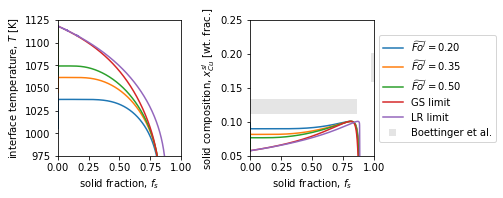

In [5]:
fig = plt.figure(figsize=(18/2.54, 7/2.54))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Calculate and plot the finite-diffusion model (without kinetics) using various modified liquid fourier numbers
for Fo in [0.2,0.35,0.5]:
    solid_fractions, temperatures, liquid_compositions, solid_compositions = step_ODE(1e-4, [0], [Fo], False)
    ax1.plot(solid_fractions, temperatures)
    ax2.plot(solid_fractions, to_mass_fraction_cu(solid_compositions), label='$\widetilde{Fo}^l = %0.2f$' % Fo)
    
# Calculate and plot the Gulliver-Scheil limit (using the equilibrium phase diagram)
solid_fractions_gs, temperatures_gs, liquid_compositions_gs, solid_compositions_gs = step_ODE(1e-4, [0], [1e3], False)
ax1.plot(solid_fractions_gs, temperatures_gs)
ax2.plot(solid_fractions_gs, to_mass_fraction_cu(solid_compositions_gs), label='GS limit')

# Calculate and plot the lever-rule limit (using the equilibrium phase diagram)
solid_fractions_lr, temperatures_lr, liquid_compositions_lr, solid_compositions_lr = step_ODE(1e-4, [1e3], [1e3], False)
ax1.plot(solid_fractions_lr, temperatures_lr)
ax2.plot(solid_fractions_lr, to_mass_fraction_cu(solid_compositions_lr),label='LR limit')

# Add experimental range from Boettinger et al.
ax2.add_patch(Rectangle((0,.1121),0.8685,.0222, facecolor='black', alpha=0.1,zorder=-1))
ax2.add_patch(Rectangle((0.9766,.1597),1-0.9766,.0425, facecolor='black', alpha=0.1,zorder=-1))
ax2.scatter([],[], s=50, marker='s', edgecolor='none', facecolor='black', alpha=0.1, label='Boettinger et al.')

# Format plot
ax1.set_xlim([0,1])
ax1.set_ylim([975,1125])
ax2.set_xlim([0,1])
ax2.set_ylim([0.05,0.25])
ax1.set_xlabel('solid fraction, $f_s$')
ax1.set_ylabel('interface temperature, $T$ [K]')
ax2.set_xlabel('solid fraction, $f_s$')
ax2.set_ylabel('solid composition, $x_{Cu}^{sl}$ [wt. frac.]')
ax2.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.tight_layout()


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
<ipython-input-3-50b0343cc843>:24: RuntimeWarning: invalid value encountered in log
  F_t2 = self.R*self.T * (self.xb*np.log(self.xb) + (1-self.xb)*np.log(1-self.xb))
<ipython-input-3-50b0343cc843>:33: RuntimeWarning: invalid value encountered in log
  t3 = self.R*self.T*np.log(self.xb/(1-self.xb))
<ipython-input-3-50b0343cc843>:42: RuntimeWarning: invalid value encountered in log
  t3 = self.R*self.T*np.log(self.xb/(1-self.xb))


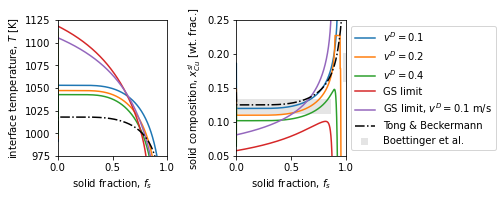

In [6]:
fig = plt.figure(figsize=(18/2.54,7/2.54))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Calculate and plot the finite-diffusion model (with kinetics) using various trans-interface diffusive speeds
for vd in [0.1,0.2,0.4]:
    solid_fractions, temperatures, liquid_compositions, solid_compositions = step_ODE(1e-4, [0], [0.2], True,[0.3,850,vd])
    ax1.plot(solid_fractions, temperatures)
    ax2.plot(solid_fractions, to_mass_fraction_cu(solid_compositions), label='$v^D = %0.1f$' % vd)
    
# Calculate and plot the Gulliver-Scheil limit (using the equilibrium phase diagram)
solid_fractions_gs, temperatures_gs, liquid_compositions_gs, solid_compositions_gs = step_ODE(1e-4, [0], [1e3], False)
ax1.plot(solid_fractions_gs, temperatures_gs)
ax2.plot(solid_fractions_gs, to_mass_fraction_cu(solid_compositions_gs), label='GS limit')

# Calculate and plot the Gulliver-Scheil limit (using the non-equilibrium phase diagram)
solid_fractions_gs2, temperatures_gs2, liquid_compositions_gs2, solid_compositions_gs2 = step_ODE(1e-4, [0], [1e3], True, [0.3,850,0.1])
ax1.plot(solid_fractions_gs2, temperatures_gs2)
ax2.plot(solid_fractions_gs2, to_mass_fraction_cu(solid_compositions_gs2), label='GS limit, $v^D=0.1$ m/s')

# Plot the Tong and Beckermann solution
ax1.plot(TB_solution.t, 1118.25-800*TB_solution.y[0], '-.k', zorder=5, label='Tong & Beckermann')
ax2.plot(TB_solution.t, TB_solution.y[0], '-.k', zorder=5, label='Tong & Beckermann')

# Add experimental range from Boettinger et al.
ax2.add_patch(Rectangle((0,.1121),0.8685,.0222, facecolor='black', alpha=0.1,zorder=-1))
ax2.add_patch(Rectangle((0.9766,.1597),1-0.9766,.0425, facecolor='black', alpha=0.1,zorder=-1))
ax2.scatter([],[], s=50, marker='s', edgecolor='none', facecolor='black', alpha=0.1, label='Boettinger et al.')

# Format plot
ax1.set_xlim([0,1])
ax1.set_ylim([975,1125])
ax2.set_xlim([0,1])
ax2.set_ylim([0.05,0.25])
ax1.set_xlabel('solid fraction, $f_s$')
ax1.set_ylabel('interface temperature, $T$ [K]')
ax2.set_xlabel('solid fraction, $f_s$')
ax2.set_ylabel('solid composition, $x_{Cu}^{sl}$ [wt. frac.]')
ax2.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.tight_layout()


In [7]:
def functions_for_spinodal(temperature, composition):
    """Defines the function needed to calculate the spinodal temperature."""
    solid = AgCu_Murray1984(temperature, composition, 'solid')
    return solid.d2G_dx2()


def calculate_phase_boundaries(liquid_compositions, kinetics=False, kinetic_parameters=[]):
    """Calculate the tie-line and spinodal temperature for specified liquid compositions."""
    solid_compositions = []
    temperatures = []
    spinodal_temperatures = []
    
    for i, xl in enumerate(liquid_compositions):
            
        # Obtain the tie-line and spinodal temperature at the current liquid composition
        if kinetics == True:
            if i == 0: # use the melting point as the intial guess
                roots  = fsolve(functions_for_nonequilibrium_liquidus, [liquid_compositions[0], 1235], args=(xl, True, kinetic_parameters)) 
                spinodal_roots = fsolve(functions_for_spinodal, x0=100, args=(xl))
            else: # use old solution as initial guess
                roots  = fsolve(functions_for_nonequilibrium_liquidus, roots, args=(xl, 0.12, kinetic_parameters)) 
                spinodal_roots = fsolve(functions_for_spinodal, spinodal_roots, args=(xl))
        elif kinetics == False:
            if i == 0: # use the melting point as the intial guess
                roots  = fsolve(functions_for_equilibrium_liquidus, [liquid_compositions[0], 1235], args=(xl)) 
                spinodal_roots = fsolve(functions_for_spinodal, x0=100, args=(xl))
            else: # use old solution as initial guess
                roots  = fsolve(functions_for_equilibrium_liquidus, roots, args=(xl)) 
                spinodal_roots = fsolve(functions_for_spinodal, spinodal_roots, args=(xl))

        solid_compositions.append(roots[0])
        temperatures.append(roots[1])
        spinodal_temperatures.append(spinodal_roots)

    return np.asarray(solid_compositions), liquid_compositions, np.asarray(temperatures), np.asarray(spinodal_temperatures)


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
<ipython-input-3-50b0343cc843>:24: RuntimeWarning: invalid value encountered in log
  F_t2 = self.R*self.T * (self.xb*np.log(self.xb) + (1-self.xb)*np.log(1-self.xb))
<ipython-input-3-50b0343cc843>:33: RuntimeWarning: invalid value encountered in log
  t3 = self.R*self.T*np.log(self.xb/(1-self.xb))
<ipython-input-3-50b0343cc843>:42: RuntimeWarning: invalid value encountered in log
  t3 = self.R*self.T*np.log(self.xb/(1-self.xb))
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
<ipython-input-3-50b0343cc843>:24: RuntimeWarning: invalid value encountered in log
  F_t2 = self.R

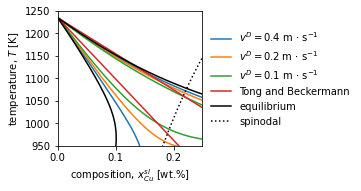

In [8]:
fig = plt.figure(figsize=(13/2.54,7/2.54))
ax = fig.add_subplot(111)
colors = ['#1f77b4','#ff7f0e','#2ca02c']

# Calculate the kinetic phase boundaries for different trans-interface diffusive speeds
for i,vd in enumerate([0.4,0.2,0.1]):
    xs, xl, T, __ = calculate_phase_boundaries(np.linspace(0.001,0.8,250), True, [0.3, 850, vd])
    ax.plot(to_mass_fraction_cu(xs), T, color=colors[i],label='$v^D = %0.1f$ m $\cdot$ s$^{-1}$' % vd)
    ax.plot(to_mass_fraction_cu(xl), T, color=colors[i])

# Calculate the Tong and Beckermann phase boundaries
ax.plot(xl, 1235-800*xl, '-', color='tab:red', label='Tong and Beckermann')
ax.plot(xl*0.588, 1235-800*xl, '-', color='tab:red')

# Calculate the equilibrium phase boundaries and spinodal
xs_eq, xl_eq, T_eq, T_spin = calculate_phase_boundaries(np.linspace(0.001,0.8,250))
ax.plot(to_mass_fraction_cu(xs_eq),T_eq, '-k',label='equilibrium')
ax.plot(to_mass_fraction_cu(xl_eq),T_eq, '-k')
ax.plot(to_mass_fraction_cu(xl_eq),T_spin, ':k',label='spinodal')

# Format plot
ax.set_xlim([0,0.25])
ax.set_ylim([950,1250])
ax.set_xlabel('composition, $x_{Cu}^{sl}$ [wt.%]')
ax.set_ylabel('temperature, $T$ [K]')
ax.legend(frameon=False,loc='center left',bbox_to_anchor=(1,0.5))
plt.tight_layout()

